In [4]:
!pip install faiss-cpu
!pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Introduction
This notebook contains our initial experiments, where we ran our searching methods on synthetically generated data.

###Note: To run our full project on a subset of the Spotify dataset, read the readme!

In [12]:
import numpy as np
from scipy.cluster.hierarchy import linkage, to_tree
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.neighbors import KDTree
import time
import faiss
from annoy import AnnoyIndex
from sklearn.neighbors import BallTree

def search_tree(tree, query_vector, data_matrix, k=1):
    if tree.is_leaf():
        return [tree.id]
    
    left_child = tree.get_left()
    right_child = tree.get_right()
    
    left_centroid = np.mean(data_matrix[left_child.pre_order()], axis=0)
    right_centroid = np.mean(data_matrix[right_child.pre_order()], axis=0)
    
    dist_left = np.linalg.norm(query_vector - left_centroid)
    dist_right = np.linalg.norm(query_vector - right_centroid)
    
    if dist_left < dist_right:
        closest_ids = search_tree(left_child, query_vector, data_matrix, k)
        if len(closest_ids) < k:
            closest_ids += search_tree(right_child, query_vector, data_matrix, k - len(closest_ids))
    else:
        closest_ids = search_tree(right_child, query_vector, data_matrix, k)
        if len(closest_ids) < k:
            closest_ids += search_tree(left_child, query_vector, data_matrix, k - len(closest_ids))
    
    return closest_ids

def hierarchical_search(data_matrix, xq, k=5):
    linked = linkage(data_matrix, method='ward')
    tree = to_tree(linked)
    
    #Time hierarchical searching
    start_time = time.time()

    closest_ids = search_tree(tree, xq, data_matrix, k)
    distances = cdist(xq.reshape(1, -1), data_matrix[closest_ids], metric='euclidean')

    print("Hierarchical search time: {:.6f} seconds".format(time.time() - start_time))
    sorted_indices = np.argsort(distances)
    closest_ids = np.array(closest_ids)[sorted_indices]
    print(distances)
    return closest_ids

def linear_search(data_matrix, xq, k=5):
    # Time linear_search
    start_time = time.time()

    distances = cdist(xq.reshape(1, -1), data_matrix, metric='euclidean')

    print("Linear search time: {:.6f} seconds".format(time.time() - start_time))

    sorted_indices = np.argsort(distances)
    closest_ids = sorted_indices[:, :k]
    
    return closest_ids

def kd_tree_search(data_matrix, xq, k=5):
    tree = KDTree(data_matrix)

    # Time kd_tree_search
    start_time = time.time()

    distances, indices = tree.query(xq.reshape(1, -1), k=k)

    print("KD Tree search time: {:.6f} seconds".format(time.time() - start_time))
    return indices
def ball_tree_search(data_matrix, xq, k=5):
    tree = BallTree(data_matrix)

    # Time ball_tree_search
    start_time = time.time()

    distances, indices = tree.query(xq.reshape(1, -1), k=k)

    print("Ball Tree search time: {:.6f} seconds".format(time.time() - start_time))
    return indices

def annoy_search(data_matrix, xq, k=5):
    dim = data_matrix.shape[1]
    tree = AnnoyIndex(dim, 'euclidean')

    for i, vec in enumerate(data_matrix):
        tree.add_item(i, vec)

    tree.build(10)  # Number of trees to build, higher values provide better search accuracy

    # Time annoy_search
    start_time = time.time()

    indices = tree.get_nns_by_vector(xq.flatten(), k)

    print("Annoy search time: {:.6f} seconds".format(time.time() - start_time))
    return indices

def faiss_search(data_matrix, xq, k=5):
    dim = data_matrix.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(data_matrix.astype(np.float32))

    # Time faiss_search
    start_time = time.time()

    distances, indices = index.search(xq.astype(np.float32), k)

    print("FAISS search time: {:.6f} seconds".format(time.time() - start_time))
    return indices


# Generate synthetic dataset
np.random.seed(42)
cluster1 = np.random.normal(0, 1, size=(4000, 768))
cluster2 = np.random.normal(5, 1, size=(4000, 768))
cluster3 = np.random.normal(-5, 1, size=(4000, 768))

data_matrix = np.concatenate((cluster1, cluster2, cluster3), axis=0)

# Create a vector that should belong to 3rd cluster
xq = np.random.normal(-5, 1, size=(1, 768))  # Query point

# Time hierarchical_search
result_hierarchical = hierarchical_search(data_matrix, xq)
print("Hierarchical search result:", result_hierarchical)

# Time linear_search
result_linear = linear_search(data_matrix, xq)
print("Linear search result:", result_linear)

# Time kd_tree_search
result_kd_tree = kd_tree_search(data_matrix, xq)
print("KD Tree search result:", result_kd_tree)

# Time ball_tree_search
result_ball_tree = ball_tree_search(data_matrix, xq)
print("Ball Tree search result:", result_ball_tree)

# Time kd_tree_search
result_annoy = annoy_search(data_matrix, xq)
print("Annoy search result:", result_annoy)

# Time FAISS_search
result_faiss = faiss_search(data_matrix, xq)
print("Faiss search result:", result_faiss)

Hierarchical search time: 0.133246 seconds
[[37.9890466  38.63604815 38.48293781 38.77321556 38.15173849]]
Hierarchical search result: [[11239  8222  9687  8510  8614]]
Linear search time: 0.007053 seconds
Linear search result: [[10054 11902  9814  9916 11198]]
KD Tree search time: 0.009192 seconds
KD Tree search result: [[10054 11902  9814  9916 11198]]
Ball Tree search time: 0.010114 seconds
Ball Tree search result: [[10054 11902  9814  9916 11198]]
Annoy search time: 0.000498 seconds
Annoy search result: [11902, 9916, 10191, 8514, 10393]
FAISS search time: 0.004298 seconds
Faiss search result: [[10054 11902  9814  9916 11198]]


#Creating a TSNE scatter plot of chosen points

<ipython-input-16-df24aea93faf>:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


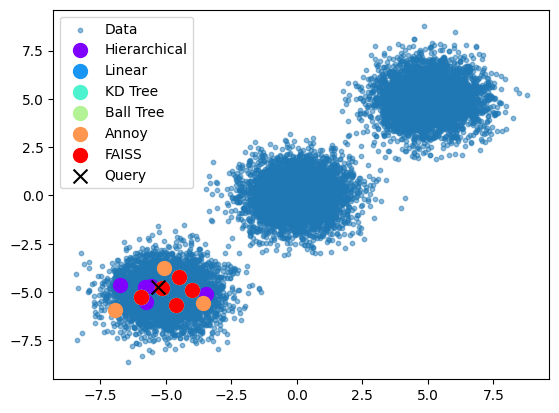

<Figure size 640x480 with 0 Axes>

In [16]:
# Create a scatter plot of the data
plt.scatter(data_matrix[:, 0], data_matrix[:, 1], s=10, alpha=0.5, label="Data")


# Plot the search results
methods = {
    "Hierarchical": result_hierarchical,
    "Linear": result_linear,
    "KD Tree": result_kd_tree,
    "Ball Tree": result_ball_tree,
    "Annoy": result_annoy,
    "FAISS": result_faiss,
}

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(methods))))

for method, result in methods.items():
    color = next(colors)
    plt.scatter(
        data_matrix[result, 0],
        data_matrix[result, 1],
        s=100,
        c=color,
        marker="o",
        label=method,
    )
# Plot the query vector
plt.scatter(xq[0, 0], xq[0, 1], s=100, c="black", marker="x", label="Query")

# Add a legend
plt.legend(loc="best")

# Show the plot
plt.show()
plt.clf()

#Plot of Running Times (Log Scale)

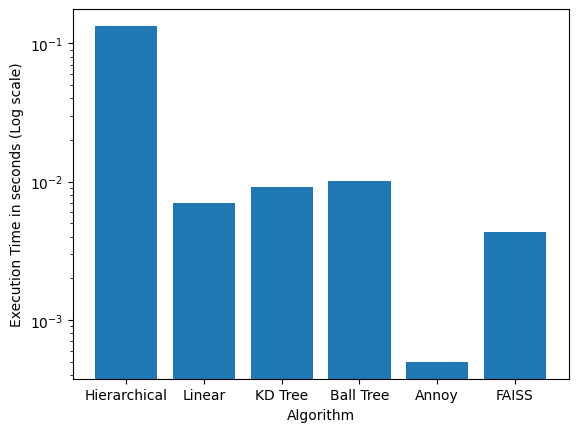

In [22]:
import matplotlib.pyplot as plt

data = [0.133246, 0.007053, 0.009192, 0.010114, 0.000498, 0.004298]
labels = ['Hierarchical', 'Linear', 'KD Tree', 'Ball Tree', 'Annoy', 'FAISS']

plt.bar(labels, data)
plt.xlabel('Algorithm')
plt.ylabel('Execution Time in seconds (Log scale)')
# plt.title('Comparison of Execution Time for Search Algorithms')
plt.yscale('log')

plt.show()
